In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Creating Training data for Batsmen Player performance predicition

In [21]:
matches = pd.read_csv('/content/drive/My Drive/hackathon/matches.csv')
raw_data = pd.read_csv('/content/drive/My Drive/hackathon/raw_data.csv')

with open('/content/drive/My Drive/hackathon/home_stadium.pkl', 'rb') as pickle_file:
    home_stadium = pickle.load(pickle_file)

<ipython-input-21-6846ae71e8e0>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('/content/drive/My Drive/hackathon/raw_data.csv')


In [22]:
raw_data.columns

Index(['Unnamed: 0', 'match_id', 'batter', 'batting_team', 'bowling_team',
       'batsman_runs', 'bowler', 'total_runs', 'is_wicket', 'id', 'season',
       'date', 'venue', 'team1', 'team2', 'toss_winner', 'winner', 'city'],
      dtype='object')

## Aggregating runs, No. of 4's and No. of 6's scored by each batsman in a match

In [23]:
batsman_stats = raw_data.groupby(['date','match_id', 'batter','venue','city','batting_team','winner','bowling_team']).agg(
    total_runs=pd.NamedAgg(column='batsman_runs', aggfunc='sum'),
    fours=pd.NamedAgg(column='batsman_runs', aggfunc=lambda x: (x == 4).sum()),
    sixes=pd.NamedAgg(column='batsman_runs', aggfunc=lambda x: (x == 6).sum()),
    strike_rate=pd.NamedAgg(column='batsman_runs', aggfunc=lambda x: (x.sum() / len(x)) * 100),
    balls_faced=pd.NamedAgg(column='batsman_runs', aggfunc=lambda x: (x != 0).sum())
).reset_index()
batsman_stats['half_century'] = batsman_stats['total_runs'].apply(lambda x: 1 if x >= 50 else 0)
batsman_stats['century'] = batsman_stats['total_runs'].apply(lambda x: 1 if x >= 100 else 0)

In [24]:
batsman_stats

,date,match_id,batter,venue,city,batting_team,winner,bowling_team,total_runs,fours,sixes,strike_rate,balls_faced,half_century,century
0,2008-04-18,335982,AA Noffke,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bengaluru,Kolkata Knight Riders,Kolkata Knight Riders,9,1,0,75.000000,6,0,0
1,2008-04-18,335982,B Akhil,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bengaluru,Kolkata Knight Riders,Kolkata Knight Riders,0,0,0,0.000000,0,0,0
2,2008-04-18,335982,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,Royal Challengers Bengaluru,158,10,13,205.194805,54,1,1
3,2008-04-18,335982,CL White,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bengaluru,Kolkata Knight Riders,Kolkata Knight Riders,6,0,0,60.000000,5,0,0
4,2008-04-18,335982,DJ Hussey,M Chinnaswamy Stadium,Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,Royal Challengers Bengaluru,12,1,0,100.000000,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16470,2024-05-26,1426312,SP Narine,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Kolkata Knight Riders,Kolkata Knight Riders,Sunrisers Hyderabad,6,0,1,300.000000,1,0,0
16471,2024-05-26,1426312,SS Iyer,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Kolkata Knight Riders,Kolkata Knight Riders,Sunrisers Hyderabad,6,1,0,200.000000,3,0,0
16472,2024-05-26,1426312,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,8,0,1,114.285714,2,0,0
16473,2024-05-26,1426312,TM Head,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,0,0,0,0.000000,0,0,0


In [25]:
total_win = raw_data.winner.value_counts()
total_matches = (raw_data.team1.value_counts()+ raw_data.team2.value_counts())
win_percentage = total_win/total_matches
win_percentage.sort_values(ascending=False)

,count
Gujarat Titans,0.629273
Rising Pune Supergiant,0.622518
Chennai Super Kings,0.584636
Lucknow Super Giants,0.564522
Mumbai Indians,0.550173
...,...
Delhi Daredevils,0.420950
Kochi Tuskers Kerala,0.413642
Deccan Chargers,0.388037
Rising Pune Supergiants,0.345853


In [26]:
win_percentage.to_csv('/content/drive/My Drive/hackathon/opponent_strength_lookup.csv')

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [28]:
df = batsman_stats.sort_values(by=['batter', 'date'])
df['current_form_total_runs'] = df.groupby('batter')['total_runs'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df['current_form_fours'] = df.groupby('batter')['fours'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df['current_form_sixes'] = df.groupby('batter')['sixes'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df['current_form_strike_rate'] = df.groupby('batter')['strike_rate'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df['current_form_balls_faced'] = df.groupby('batter')['balls_faced'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df['career_avg_total_runs'] = df.groupby('batter')['total_runs'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df['career_avg_fours'] = df.groupby('batter')['fours'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df['career_avg_sixes'] = df.groupby('batter')['sixes'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df['career_avg_strike_rate'] = df.groupby('batter')['strike_rate'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df['career_avg_balls_faced'] = df.groupby('batter')['balls_faced'].expanding().mean().shift(1).reset_index(level=0, drop=True)
df['half_century_prob'] = df.groupby('batter')['half_century'].expanding().sum().shift(1).reset_index(level=0, drop=True) / df.groupby('batter').cumcount()
df['century_prob'] = df.groupby('batter')['century'].expanding().sum().shift(1).reset_index(level=0, drop=True) / df.groupby('batter').cumcount()
df['is_win'] = (df['winner'] == df['batting_team'])
df['opponent_strength'] = win_percentage[df['bowling_team']].values
df['boundary_percentage'] = df.groupby(['batter', 'match_id']).apply(
    lambda x: ((x['fours'].sum() + x['sixes'].sum()) / x['balls_faced'].sum()) * 100
).reset_index(level=[0, 1], drop=True)
df['avg_boundary_percentage'] = df.groupby('batter')['boundary_percentage'].rolling(window=7, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df['avg_boundary_percentage'].fillna(0, inplace=True)
df['avg_boundary_percentage'].replace([np.inf, -np.inf], 0, inplace=True)

def is_home_match(row, team_home_info):
    team = row['batting_team']
    city = row['city']

    if team in home_stadium:
        home_cities = [info[0] for info in home_stadium[team]]
        return True if city in home_cities else False
    return False

df['is_home_match'] = df.apply(is_home_match, axis=1, team_home_info=home_stadium)
df

<ipython-input-28-19702084a4d9>:17: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: ((x['fours'].sum() + x['sixes'].sum()) / x['balls_faced'].sum()) * 100


,date,match_id,batter,venue,city,batting_team,winner,bowling_team,total_runs,fours,sixes,strike_rate,balls_faced,half_century,century,current_form_total_runs,current_form_fours,current_form_sixes,current_form_strike_rate,current_form_balls_faced,career_avg_total_runs,career_avg_fours,career_avg_sixes,career_avg_strike_rate,career_avg_balls_faced,half_century_prob,century_prob,is_win,opponent_strength,boundary_percentage,avg_boundary_percentage,is_home_match
4286,2012-04-29,548346,A Ashish Reddy,Wankhede Stadium,Mumbai,Deccan Chargers,Mumbai Indians,Mumbai Indians,10,0,1,100.000000,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.550173,27.586207,0.000000,False
4377,2012-05-04,548352,A Ashish Reddy,"MA Chidambaram Stadium, Chepauk",Chennai,Deccan Chargers,Chennai Super Kings,Chennai Super Kings,3,0,0,100.000000,2,0,0,10.000000,0.000000,1.000000,100.000000,4.000000,10.000000,0.000000,1.000000,100.000000,4.000000,0.0,0.0,False,0.584636,NaN,27.586207,False
4483,2012-05-08,548359,A Ashish Reddy,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,Deccan Chargers,Punjab Kings,Punjab Kings,8,1,0,100.000000,5,0,0,6.500000,0.000000,0.500000,100.000000,3.000000,6.500000,0.000000,0.500000,100.000000,3.000000,0.0,0.0,False,0.456485,46.666667,27.586207,True
4694,2012-05-18,548373,A Ashish Reddy,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,Deccan Chargers,Deccan Chargers,Rajasthan Royals,10,2,0,250.000000,3,0,0,7.000000,0.333333,0.333333,100.000000,3.666667,7.000000,0.333333,0.333333,100.000000,3.666667,0.0,0.0,True,0.514887,0.000000,37.126437,True
4742,2012-05-20,548376,A Ashish Reddy,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,Deccan Chargers,Deccan Chargers,Royal Challengers Bengaluru,4,0,0,80.000000,3,0,0,7.750000,0.750000,0.250000,137.500000,3.500000,7.750000,0.750000,0.250000,137.500000,3.500000,0.0,0.0,True,0.484141,55.555556,24.750958,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7756,2016-04-10,980903,Z Khan,Eden Gardens,Kolkata,Delhi Daredevils,Kolkata Knight Riders,Kolkata Knight Riders,4,1,0,44.444444,1,0,0,2.857143,0.142857,0.142857,67.687075,1.571429,4.863636,0.454545,0.090909,82.104978,2.727273,0.0,0.0,False,0.520810,0.000000,28.748712,False
8390,2016-05-15,980993,Z Khan,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,Visakhapatnam,Delhi Daredevils,Mumbai Indians,Mumbai Indians,2,0,0,50.000000,2,0,0,1.857143,0.142857,0.142857,51.587302,0.714286,4.826087,0.478261,0.086957,80.467564,2.652174,0.0,0.0,False,0.550173,33.333333,22.626263,False
8665,2017-04-08,1082595,Z Khan,M.Chinnaswamy Stadium,Bengaluru,Delhi Daredevils,Royal Challengers Bengaluru,Royal Challengers Bengaluru,1,0,0,100.000000,1,0,0,2.142857,0.142857,0.142857,58.730159,1.000000,4.708333,0.458333,0.083333,79.198082,2.625000,0.0,0.0,False,0.484141,33.333333,22.626263,False
9265,2017-05-06,1082635,Z Khan,Feroz Shah Kotla,Delhi,Delhi Daredevils,Mumbai Indians,Mumbai Indians,2,0,0,18.181818,2,0,0,2.142857,0.142857,0.142857,68.253968,1.000000,4.560000,0.440000,0.080000,80.030159,2.560000,0.0,0.0,False,0.550173,50.000000,21.038961,True


In [29]:
df.columns

Index(['date', 'match_id', 'batter', 'venue', 'city', 'batting_team', 'winner',
       'bowling_team', 'total_runs', 'fours', 'sixes', 'strike_rate',
       'balls_faced', 'half_century', 'century', 'current_form_total_runs',
       'current_form_fours', 'current_form_sixes', 'current_form_strike_rate',
       'current_form_balls_faced', 'career_avg_total_runs', 'career_avg_fours',
       'career_avg_sixes', 'career_avg_strike_rate', 'career_avg_balls_faced',
       'half_century_prob', 'century_prob', 'is_win', 'opponent_strength',
       'boundary_percentage', 'avg_boundary_percentage', 'is_home_match'],
      dtype='object')

## Checking Co-relation



*   Removing features that have co relation greater than 90 %



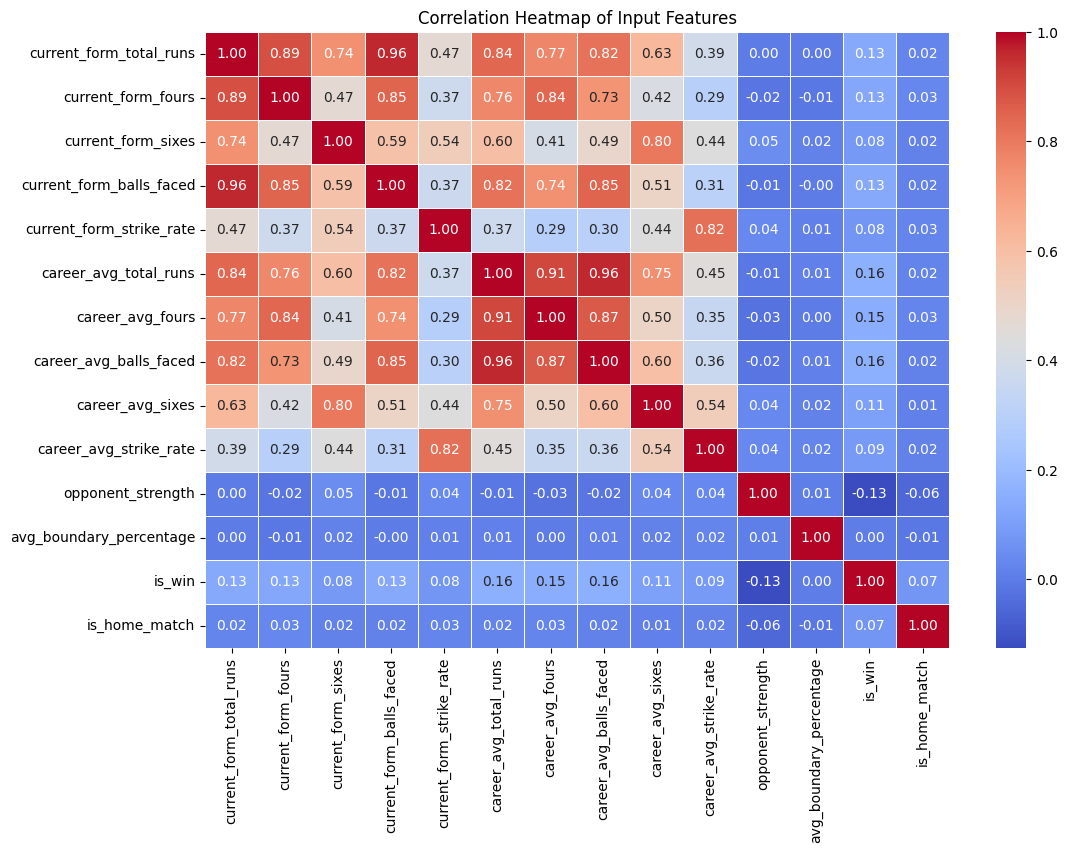

In [30]:
numerical_cols = ['current_form_total_runs', 'current_form_fours', 'current_form_sixes','current_form_balls_faced',
                  'current_form_strike_rate', 'career_avg_total_runs', 'career_avg_fours','career_avg_balls_faced',
                  'career_avg_sixes', 'career_avg_strike_rate','opponent_strength','avg_boundary_percentage',
                  'is_win', 'is_home_match']

correlation_matrix = df[numerical_cols].corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Input Features')
plt.show()

Removed columns due to high correlation: ['current_form_balls_faced', 'career_avg_fours', 'career_avg_balls_faced']


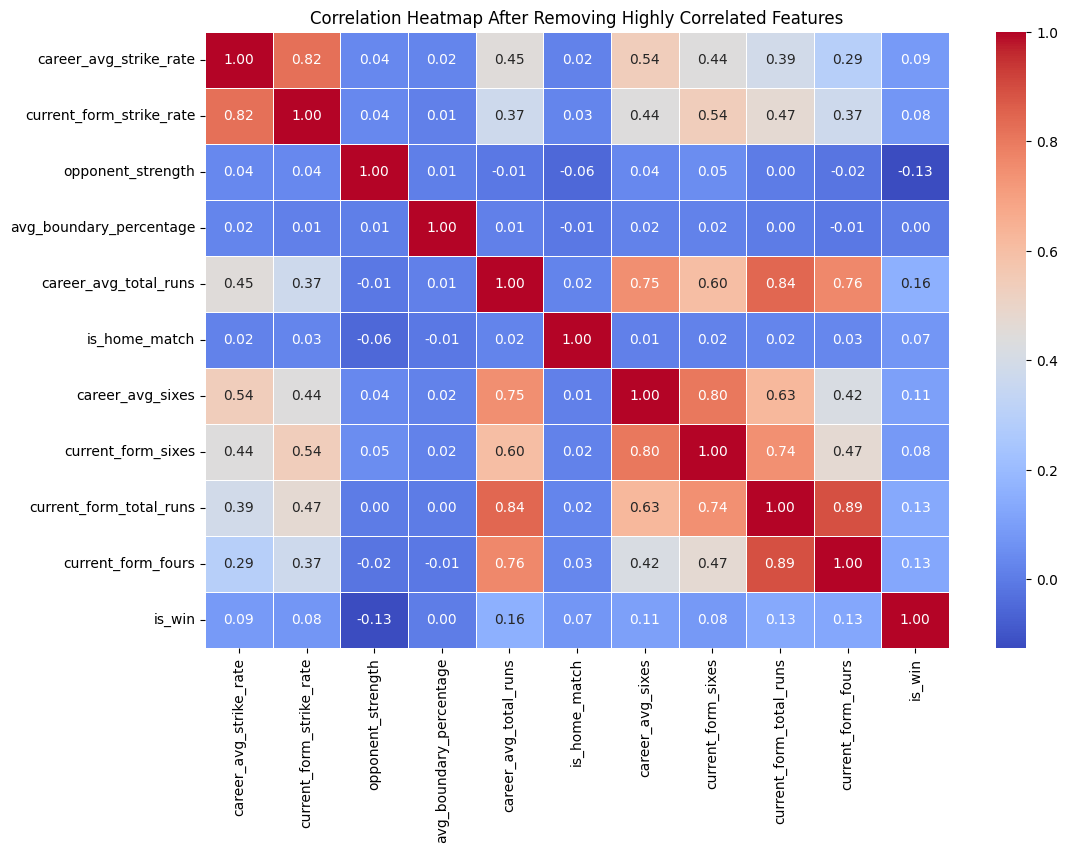

In [31]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df_reduced = df.drop(columns=to_drop)

print(f"Removed columns due to high correlation: {to_drop}")

numerical_cols = list(set(numerical_cols) - set(to_drop))
plt.figure(figsize=(12, 8))
sns.heatmap(df_reduced[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap After Removing Highly Correlated Features')
plt.show()

# Model Training

*   For training we are using match data until 2023
*   For testing we are using match data of 2024



In [32]:
df['date'] = pd.to_datetime(df['date'])


train_data = df[df['date'].dt.year <= 2023]
test_data = df[df['date'].dt.year == 2024]


input_features = ['batter',
                  'current_form_total_runs', 'current_form_fours', 'current_form_sixes','current_form_balls_faced',
                  'current_form_strike_rate', 'career_avg_total_runs', 'career_avg_fours','career_avg_balls_faced',
                  'career_avg_sixes', 'career_avg_strike_rate','opponent_strength','avg_boundary_percentage',
                  'is_win', 'is_home_match']

In [33]:
input_features = list(set(input_features) - set(to_drop))
print(input_features)

output_features = ['total_runs', 'fours', 'sixes', 'strike_rate', 'boundary_percentage','century_prob', 'half_century_prob']

categorical_cols = ['batter']


train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_cleaned = train_data.dropna(subset=input_features + output_features)

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data_cleaned = test_data.dropna(subset=input_features + output_features)

['career_avg_strike_rate', 'current_form_strike_rate', 'opponent_strength', 'avg_boundary_percentage', 'career_avg_total_runs', 'is_home_match', 'batter', 'career_avg_sixes', 'current_form_sixes', 'current_form_total_runs', 'current_form_fours', 'is_win']


<ipython-input-33-68385c57717c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-33-68385c57717c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [34]:
X_train = train_data_cleaned[input_features]
y_train = train_data_cleaned[output_features]

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data_cleaned = test_data.dropna(subset=input_features + output_features)
X_test = test_data_cleaned
y_test = test_data_cleaned[output_features]


train_players = X_train['batter'].unique()
test_players = X_test['batter'].unique()


missing_players = set(test_players) - set(train_players)


X_test_cleaned = X_test[~X_test['batter'].isin(missing_players)]
X_test_cleaned_df = X_test_cleaned[input_features]
y_test_cleaned = y_test.loc[X_test_cleaned.index]

<ipython-input-34-d39cf8b1af0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [35]:
X_test_cleaned.to_csv('/content/drive/My Drive/hackathon/stream_X_test_batsmen_24.csv')

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)))])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['current_form_strike_rate',
                                                   'career_avg_total_runs',
                                                   'opponent_strength',
                                                   'current_form_total_runs',
                                                   'is_home_match',
                                                   'career_avg_strike_rate',
                                                   'is_win', 'career_avg_sixes',
                                                   'current_form_fours',
                                                   'current_form_sixes',
                                                   'avg_boundary_percentage']),
                                                 ('cat', OneHotEncoder(),
                                                  ['batter'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42)))])

In [40]:
with open('/content/drive/MyDrive/hackathon/batsmen_08_23.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [41]:
y_pred = model.predict(X_test_cleaned)

mse = mean_squared_error(y_test_cleaned, y_pred, multioutput='raw_values')
print(f'Mean Squared Error for each output: {mse}')

Mean Squared Error for each output: [4.78101174e+02 5.41576289e+00 2.69925647e+00 5.26025043e+03
 5.83125017e+02 1.15369329e-04 9.97169093e-04]


In [42]:
with open('/content/drive/MyDrive/hackathon/dummy/batsmen_08_23.pkl', 'rb') as model_file:
    model_old = pickle.load(model_file)

In [43]:
y_pred_old = model_old.predict(X_test_cleaned)

mse_old = mean_squared_error(y_test_cleaned, y_pred_old, multioutput='raw_values')
print(f'Mean Squared Error for each output: {mse_old}')

Mean Squared Error for each output: [4.84413778e+02 5.51372677e+00 2.71876279e+00 5.38641387e+03
 5.65351744e+02 1.18848711e-04 9.63348916e-04]


Storing dataframes for futher use

In [45]:
test_data_cleaned.to_csv('/content/drive/My Drive/hackathon/streamlit_X_test_batsmen_24.csv')

In [46]:
teams = [
    'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
    'Chennai Super Kings', 'Sunrisers Hyderabad',
    'Delhi Capitals', 'Punjab Kings', 'Lucknow Super Giants',
    'Gujarat Titans', 'Royal Challengers Bengaluru'
]


filtered_data = test_data_cleaned[
    (test_data_cleaned['bowling_team'].isin(teams))
]

player_teams = {}

for player, group in filtered_data.groupby('batter'):
    teams_played_against = set(group['bowling_team'].unique())
    teams_played_against = teams_played_against.intersection(teams)
    player_teams[player] = list(teams_played_against)


for player in player_teams:
    player_teams[player] = sorted(set(player_teams[player]))

import json
player_teams_json = json.dumps(player_teams, indent=4)


with open('/content/drive/My Drive/hackathon/batsman_teams.json', 'w') as json_file:
    json.dump(player_teams, json_file, indent=4)

In [22]:
import pickle
with open('/content/drive/My Drive/hackathon/batsmen_08_23.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
train_players_df = pd.DataFrame(train_players, columns=['batter'])
train_players_df.to_csv('/content/drive/My Drive/hackathon/train_batsmen_08_23.csv', index=False)

In [ ]:
X_train.to_csv('/content/drive/My Drive/hackathon/X_train_batsmen_08_23.csv', index=False)
y_train.to_csv('/content/drive/My Drive/hackathon/y_train_batsmen_08_23.csv', index=False)
X_test_cleaned.to_csv('/content/drive/My Drive/hackathon/X_test_batsmen_24.csv', index=False)
y_test_cleaned.to_csv('/content/drive/My Drive/hackathon/y_test_batsmen_24.csv', index=False)

In [ ]:
train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])

train_data_cleaned = train_data_cleaned.sort_values(by=['batter', 'date'])

last_match_data = train_data_cleaned.groupby('batter').tail(1)
last_match_data.to_csv('/content/drive/My Drive/hackathon/last_match_data_batsman.csv', index=False)

<ipython-input-31-19c21f18602e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_cleaned['date'] = pd.to_datetime(train_data_cleaned['date'])


In [44]:
y_pred = model.predict(X_test_cleaned)

y_pred_df = pd.DataFrame(y_pred, columns=output_features, index=X_test_cleaned.index)

results_df = X_test_cleaned.copy()
results_df['actual_total_runs'] = y_test_cleaned['total_runs']
results_df['predicted_total_runs'] = y_pred_df['total_runs']

results_df['actual_fours'] = y_test_cleaned['fours']
results_df['predicted_fours'] = y_pred_df['fours']

results_df['actual_sixes'] = y_test_cleaned['sixes']
results_df['predicted_sixes'] = y_pred_df['sixes']

results_df['actual_strike_rate'] = y_test_cleaned['strike_rate']
results_df['predicted_strike_rate'] = y_pred_df['strike_rate']

results_df['actual_half_century_prob'] = y_test_cleaned['half_century_prob']
results_df['predicted_half_century_prob'] = y_pred_df['half_century_prob']

results_df['actual_century_prob'] = y_test_cleaned['century_prob']
results_df['predicted_century_prob'] = y_pred_df['century_prob']

results_df

,date,match_id,batter,venue,city,batting_team,winner,bowling_team,total_runs,fours,sixes,strike_rate,balls_faced,half_century,century,current_form_total_runs,current_form_fours,current_form_sixes,current_form_strike_rate,current_form_balls_faced,career_avg_total_runs,career_avg_fours,career_avg_sixes,career_avg_strike_rate,career_avg_balls_faced,half_century_prob,century_prob,is_win,opponent_strength,boundary_percentage,avg_boundary_percentage,is_home_match,actual_total_runs,predicted_total_runs,actual_fours,predicted_fours,actual_sixes,predicted_sixes,actual_strike_rate,predicted_strike_rate,actual_half_century_prob,predicted_half_century_prob,actual_century_prob,predicted_century_prob
15409,2024-03-24,1422122,A Badoni,"Sawai Mansingh Stadium, Jaipur",Jaipur,Lucknow Super Giants,Rajasthan Royals,Rajasthan Royals,1,0,0,20.000000,1,0,0,14.714286,0.857143,0.857143,95.659864,7.000000,15.454545,1.000000,0.681818,111.528943,7.863636,0.045455,0.000000,False,0.514887,0.000000,23.927739,False,1,13.60,0,0.93,0,0.24,20.000000,109.294271,0.045455,0.054061,0.000000,0.000000
15513,2024-03-30,1422129,A Badoni,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow,Lucknow Super Giants,Lucknow Super Giants,Punjab Kings,8,0,0,80.000000,7,0,0,14.714286,0.857143,0.857143,94.945578,7.000000,14.826087,0.956522,0.652174,107.549424,7.565217,0.043478,0.000000,True,0.456485,33.333333,20.897436,True,8,17.65,0,1.14,0,0.85,80.000000,135.100096,0.043478,0.052188,0.000000,0.000000
15667,2024-04-07,1422139,A Badoni,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow,Lucknow Super Giants,Lucknow Super Giants,Gujarat Titans,20,3,0,166.666667,10,0,0,8.571429,0.428571,0.428571,62.755102,4.714286,13.960000,0.880000,0.600000,102.145470,7.240000,0.040000,0.000000,True,0.629273,0.000000,24.666667,True,20,17.65,3,0.89,0,1.42,166.666667,132.958794,0.040000,0.042953,0.000000,0.000000
15748,2024-04-12,1426264,A Badoni,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow,Lucknow Super Giants,Delhi Capitals,Delhi Capitals,55,5,1,144.736842,28,1,0,10.857143,0.857143,0.428571,81.369821,5.571429,14.192308,0.961538,0.576923,104.627055,7.346154,0.038462,0.000000,False,0.525268,33.333333,24.666667,True,55,13.20,5,0.69,1,0.22,144.736842,98.014313,0.038462,0.055567,0.000000,0.000000
15780,2024-04-14,1426266,A Badoni,"Eden Gardens, Kolkata",Kolkata,Lucknow Super Giants,Kolkata Knight Riders,Kolkata Knight Riders,29,2,1,107.407407,18,0,0,15.714286,1.428571,0.285714,77.046512,8.571429,15.703704,1.111111,0.592593,106.112602,8.111111,0.074074,0.000000,False,0.520810,33.333333,26.111111,False,29,9.54,2,0.61,1,0.15,107.407407,98.748077,0.074074,0.053431,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16234,2024-05-07,1426294,YBK Jaiswal,"Arun Jaitley Stadium, Delhi",Delhi,Rajasthan Royals,Delhi Capitals,Delhi Capitals,4,1,0,200.000000,1,0,0,39.571429,4.428571,1.571429,129.949875,16.142857,31.659574,3.872340,1.276596,123.264654,12.553191,0.234043,0.042553,False,0.525268,20.000000,33.727273,False,4,20.04,1,1.27,0,0.54,200.000000,80.615969,0.234043,0.230365,0.042553,0.018911
16308,2024-05-12,1426299,YBK Jaiswal,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai,Rajasthan Royals,Chennai Super Kings,Chennai Super Kings,24,3,1,109.090909,9,0,0,40.142857,4.571429,1.571429,158.521303,16.285714,31.083333,3.812500,1.250000,124.863307,12.312500,0.229167,0.041667,False,0.584636,57.142857,26.818182,False,24,24.44,3,1.87,1,0.82,109.090909,100.140251,0.229167,0.228231,0.041667,0.020717
16362,2024-05-15,1426303,YBK Jaiswal,"Barsapara Cricket Stadium, Guwahati",Guwahati,Rajasthan Royals,Punjab Kings,Punjab Kings,4,1,0,100.000000,1,0,0,40.142857,4.285714,1.714286,156.060606,16.428571,30.938776,3.795918,1.244898,124.541422,12.244898,0.224490,0.040816,False,0.456485,30.000000,31.872294,False,4,22.88,1,1.66,0,0.67,100.000000,85.970339,0.224490,0

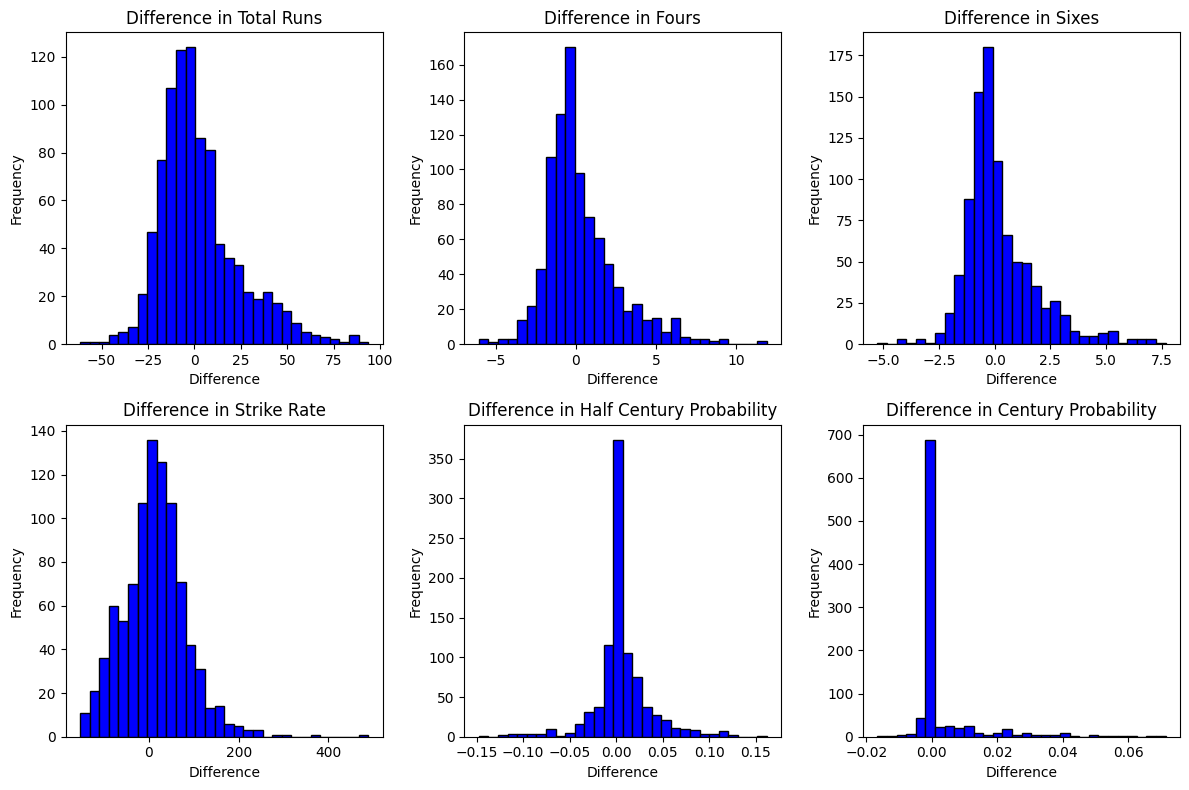

In [47]:
import matplotlib.pyplot as plt

# Calculate differences between actual and predicted values
results_df['diff_total_runs'] = results_df['actual_total_runs'] - results_df['predicted_total_runs']
results_df['diff_fours'] = results_df['actual_fours'] - results_df['predicted_fours']
results_df['diff_sixes'] = results_df['actual_sixes'] - results_df['predicted_sixes']
results_df['diff_strike_rate'] = results_df['actual_strike_rate'] - results_df['predicted_strike_rate']
results_df['diff_half_century_prob'] = results_df['actual_half_century_prob'] - results_df['predicted_half_century_prob']
results_df['diff_century_prob'] = results_df['actual_century_prob'] - results_df['predicted_century_prob']

# List of differences and their labels
diff_columns = [
    ('diff_total_runs', 'Total Runs'),
    ('diff_fours', 'Fours'),
    ('diff_sixes', 'Sixes'),
    ('diff_strike_rate', 'Strike Rate'),
    ('diff_half_century_prob', 'Half Century Probability'),
    ('diff_century_prob', 'Century Probability')
]

# Plot histograms
plt.figure(figsize=(12, 8))

for i, (col, label) in enumerate(diff_columns):
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid for subplots
    plt.hist(results_df[col], bins=30, color='blue', edgecolor='black')
    plt.title(f'Difference in {label}')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout so plots don't overlap
plt.show()